# MNIST Fashion Training and Validation

MNIST Dataset contains blurred `images` of clothes and their true labels. The goal of this project is to build a model that correctly identifies the number inputs by implementing a validation process.

First, download and load the training data.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Images and labels constantly renewing their values from testloader
images, labels = next(iter(testloader))

Next, the network was outlined with three hidden layers and one output layer. `self.dropout` was added to decrease the amount of validation loss to prevent overfitting.

In [2]:
from torch import nn, optim
import torch.nn.functional as F

# <Model Setup>

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

Then, the model was trained over 30 epochs.

In [3]:
# <network generation>
model = Classifier()
criterion = nn.NLLLoss()    # criterion for loss
optimizer = optim.Adam(model.parameters(), lr=0.003)    # optimizer for update
train_losses, test_losses = [], []  # list to appends new losses
epochs = 30


# <network processing>
for e in range(epochs):
    

    # <training>
    train_loss_sum = 0 # train loss sum at one epoch

    for images, labels in trainloader:
        
        optimizer.zero_grad()   # clears gradient descent

        output = model(images)  # train output
        train_loss = criterion(output, labels)    # train loss calculation
        train_loss.backward() # backpropagation
        optimizer.step()    # updates model

        train_loss_sum += train_loss.item()


    # <testing>    
    else:
        test_loss_sum = 0   # test loss sum at one epoch
        accuracy_sum = 0    # accuracy sum at one epoch
        
        with torch.no_grad():   # remove descents
            model.eval()    # converts to test mode

            for images, labels in testloader:

                output = model(images)  # test output
                test_loss = criterion(output, labels)  # test loss calculation

                test_loss_sum += test_loss.item()

                ps = torch.exp(output)  # probability
                top_p, top_class = ps.topk(1, dim=1)    # classes with highest probability
                equals = top_class == labels.view(*top_class.shape) # test classes vs. label
                accuracy = torch.mean(equals.type(torch.FloatTensor))  # frequency of test classes == label
                
                accuracy_sum += accuracy 
        
        model.train()   # reverts to train mode
        
        train_losses.append(train_loss_sum/len(trainloader))    # appends average train loss
        test_losses.append(test_loss/len(testloader))   # appends average test loss

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),  # newest average train loss
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),   # newest average test loss
              "Test Accuracy: {:.3f}".format(accuracy_sum/len(testloader))) # average accuracy

Epoch: 1/30..  Training Loss: 0.610..  Test Loss: 0.003..  Test Accuracy: 0.812
Epoch: 2/30..  Training Loss: 0.489..  Test Loss: 0.002..  Test Accuracy: 0.840
Epoch: 3/30..  Training Loss: 0.453..  Test Loss: 0.005..  Test Accuracy: 0.853
Epoch: 4/30..  Training Loss: 0.432..  Test Loss: 0.003..  Test Accuracy: 0.858
Epoch: 5/30..  Training Loss: 0.421..  Test Loss: 0.003..  Test Accuracy: 0.858
Epoch: 6/30..  Training Loss: 0.415..  Test Loss: 0.001..  Test Accuracy: 0.863
Epoch: 7/30..  Training Loss: 0.401..  Test Loss: 0.002..  Test Accuracy: 0.865
Epoch: 8/30..  Training Loss: 0.394..  Test Loss: 0.001..  Test Accuracy: 0.864
Epoch: 9/30..  Training Loss: 0.390..  Test Loss: 0.002..  Test Accuracy: 0.842
Epoch: 10/30..  Training Loss: 0.392..  Test Loss: 0.003..  Test Accuracy: 0.863
Epoch: 11/30..  Training Loss: 0.388..  Test Loss: 0.003..  Test Accuracy: 0.864
Epoch: 12/30..  Training Loss: 0.386..  Test Loss: 0.004..  Test Accuracy: 0.855
Epoch: 13/30..  Training Loss: 0.376.

Now, the trained model is ready for inference.

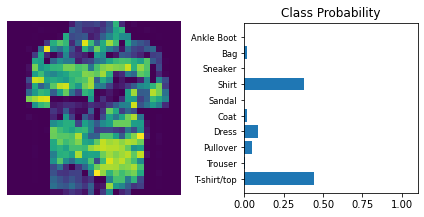

In [4]:
import helper


# <inference>
model.eval()    # converts to test mode

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
img = img.view(1, 784)  # flattens image

with torch.no_grad():
    output = model.forward(img) # inputs image
    ps = torch.exp(output)  # prabability


# <plot the image and probabilities>
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')